In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
%matplotlib widget
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
import torch
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import torchCompactRadius

/home/winchenbach/dev/torchCompactRadius/src/torchCompactRadius/compactHashing/cppWrapper.py:31: UserWarning: No precompiled version of the neighbor search is available.
  warnings.warn('No precompiled version of the neighbor search is available.')


In [1]:
import torchCompactRadius_cpu

ModuleNotFoundError: No module named 'torchCompactRadius_cpu'

In [2]:
import numpy as np
import torchCompactRadius as tcr
from torchCompactRadius import radiusSearch, volumeToSupport
from torchCompactRadius.util import countUniqueEntries
# from torchCompactRadius.radiusNaive import radiusNaive, radiusNaiveFixed
# from torchCompactRadius.cppWrapper import neighborSearchSmall, neighborSearchSmallFixed
import platform
import pandas as pd
import time
# from tqdm.autonotebook import tqdm
import copy
import seaborn as sns

def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = torch.tensor([periodic] * dim, device = device, dtype = torch.bool)

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx / 1.5
    ny = int(1 // dy)

    # print(f"dx = {dx}, dy = {dy}, h = {h}")
    # print(f"nx = {nx}, ny = {ny}")
    # print(f"minDomain = {minDomain}, maxDomain = {maxDomain}")
    # print(f"periodicity = {periodicity}")
    # print(f"dim = {dim}")
    # print(f"device = {device}")
    # print(f"maxDomain_0 = {maxDomain_0}")
    # print(f"targetNumNeighbors = {targetNumNeighbors}")
    

    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    supports = torch.ones(positions.shape[0], device = device) * h
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    ySupport = torch.ones(y.shape[0], device = device) * volumeToSupport(dy**dim, targetNumNeighbors, dim)
    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]

def test_ij(i, j, y, positions, periodic):
    try:
        if y.shape == positions.shape and torch.all(y == positions):
            if torch.any(periodic):
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 46080, f'i.shape[0] = {i.shape[0]} != 11520'
                assert j.shape[0] == 46080, f'i.shape[0] = {j.shape[0]} != 11520'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
                assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
            else:
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 41580, f'i.shape[0] = {i.shape[0]} != 41580'
                assert j.shape[0] == 41580, f'i.shape[0] = {j.shape[0]} != 41580'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() != ni.max(), f'ni.min() = {ni.min()} == ni.max() = {ni.max()}'
                assert nj.min() != nj.max(), f'nj.min() = {nj.min()} == nj.max() = {nj.max()}'

                assert ni.min() == 15, f'ni.min() = {ni.min()} != 15'
                assert ni.max() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
        else:
            assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
            assert i.shape[0] == 11520, f'i.shape[0] = {i.shape[0]} != 11520'
            assert j.shape[0] == 11520, f'i.shape[0] = {j.shape[0]} != 11520'
            ii, ni = countUniqueEntries(i, y)
            jj, nj = countUniqueEntries(j, positions)
            assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
            assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
            print('✅', end = '')
    except AssertionError as e:
        print('❌', end = '')



In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2
periodic = False
(y, x), (ySupport, xSupport), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)
h = ySupport[0].cpu().item()

from torchCompactRadius.util import DomainDescription, PointCloud

domainDescription = DomainDescription(minDomain, maxDomain, periodicity, dim)

pointCloudX = PointCloud(x, xSupport)
pointCloudY = PointCloud(y, ySupport)

# pointCloudX = PointCloud(x, None)
# pointCloudY = PointCloud(y, None)

In [4]:
# i, j = radiusSearch(pointCloudY, pointCloudX, supportOverride= h, algorithm = 'compact', domain = domainDescription, verbose = True)
# test_ij(i, j, y, x, periodic)
# i, j = radiusSearch(pointCloudX, pointCloudY, supportOverride= h, algorithm = 'compact', domain = domainDescription)
# test_ij(j, i, y, x, periodic)

In [5]:

cooAdjacency = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric')
print(cooAdjacency)


# print(i,j)

# cooNeighbors = SparseCOO(i, j, x.shape[0], y.shape[0])

# csrNeighbors = coo_to_csr(cooNeighbors, isSorted=False)
# cooNeighbors2 = csr_to_coo(csrNeighbors)

SparseCOO(row=tensor([167, 167, 168,  ..., 855, 856, 856]), col=tensor([  1,   0,   1,  ..., 575, 574, 575]), numRows=1024, numCols=576)


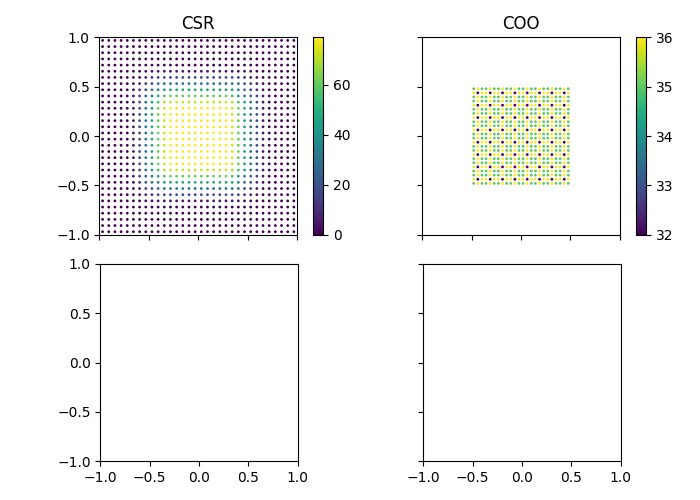

In [6]:
import matplotlib.pyplot as plt
_, numNeighborsI = countUniqueEntries(cooAdjacency.row, x)
_, numNeighborsJ = countUniqueEntries(cooAdjacency.col, y)

fig, ax = plt.subplots(2, 2, figsize = (7, 5), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

sc = ax[0,0].scatter(pointCloudX.positions[:,0], pointCloudX.positions[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
plt.colorbar(sc, ax = ax[0,0])
ax[0,0].set_title('CSR')

sc = ax[0,1].scatter(pointCloudY.positions[:,0], pointCloudY.positions[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])
ax[0,1].set_title('COO')


fig.tight_layout()

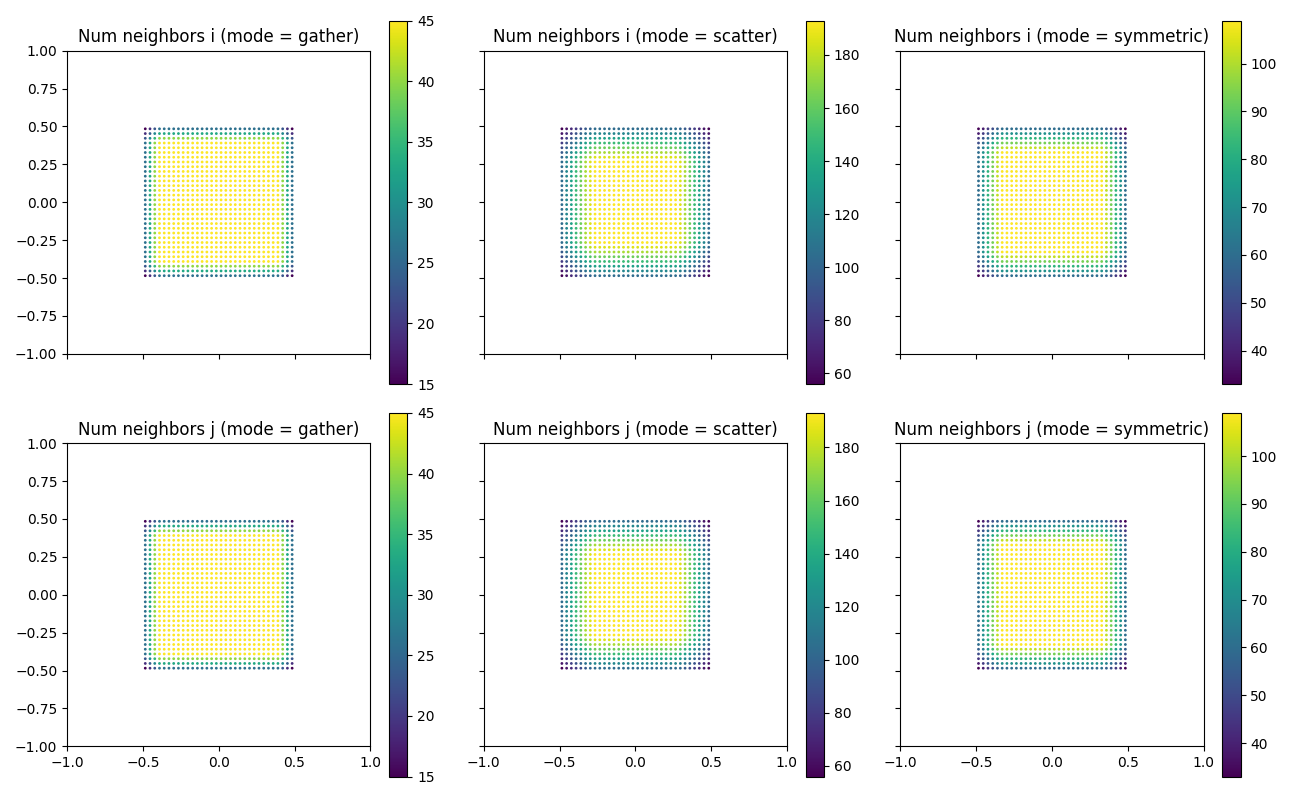

In [27]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 3, figsize = (13, 8), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

for mi, mode in enumerate(['gather', 'scatter', 'symmetric']):

    i, j = radiusSearch(pointCloudY, pointCloudY2, algorithm = 'small', domain = domainDescription, mode = mode, verbose = False)
    jj, numNeighborsJ = countUniqueEntries(j, y)
    ii, numNeighborsI = countUniqueEntries(i, y)

    sc = ax[0,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
    plt.colorbar(sc, ax = ax[0,mi])
    sc = ax[1,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
    plt.colorbar(sc, ax = ax[1,mi])

    ax[0,mi].set_title(f'Num neighbors i (mode = {mode})')
    ax[1,mi].set_title(f'Num neighbors j (mode = {mode})')


fig.tight_layout()

torch.Size([28672]) torch.Size([28672]) tensor([167, 168, 168,  ..., 855, 855, 856]) tensor([167, 168, 168,  ..., 855, 855, 856])
torch.Size([28672]) torch.Size([28672]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023])


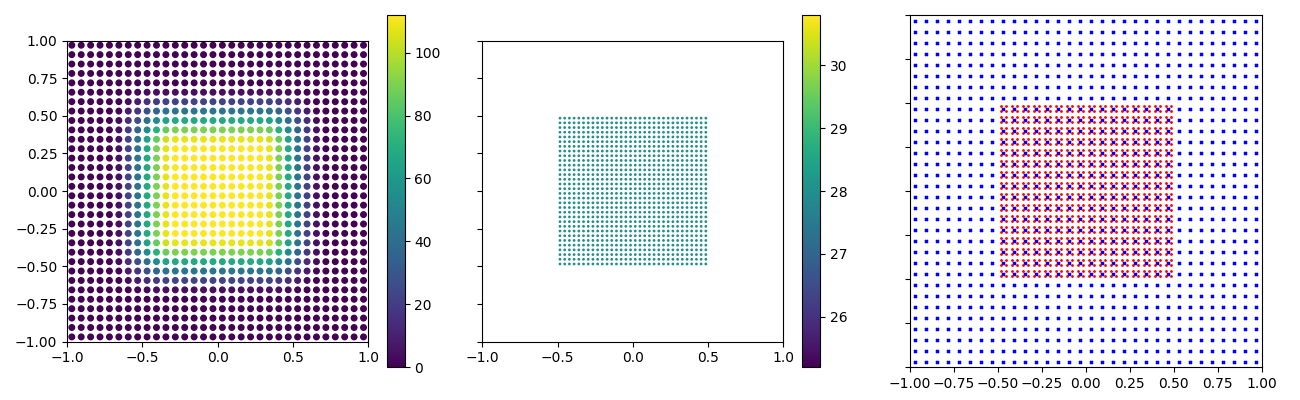

In [ ]:
from torchCompactRadius.compactHashing.datastructure import buildDataStructure
from torchCompactRadius import neighborSearchExisting
    
compactHashMap = buildDataStructure(pointCloudY, max(pointCloudX.supports.max().item(), pointCloudY.supports.max().item()), domainDescription, hashMapLength=4096)
i2,j2 = neighborSearchExisting(pointCloudX, compactHashMap, mode = 'symmetric')


# i, j, structure = radiusSearch(x, y, fixedSupport= torch.tensor(h, dtype = x.dtype, device = x.device), algorithm = 'small', domain = domainDescription, mode = 'gather', returnStructure=True)
i, j, compactHashMap = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric', returnStructure=True)

print(i.shape, i2.shape, i, i2)
print(j.shape, j2.shape, j, j2)

assert torch.all(i == i2)
assert torch.all(j == j2)

jj, numNeighborsJ = countUniqueEntries(j, y)
ii, numNeighborsI = countUniqueEntries(i, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()

torch.Size([28672]) torch.Size([28672])
torch.Size([28672]) torch.Size([28672])


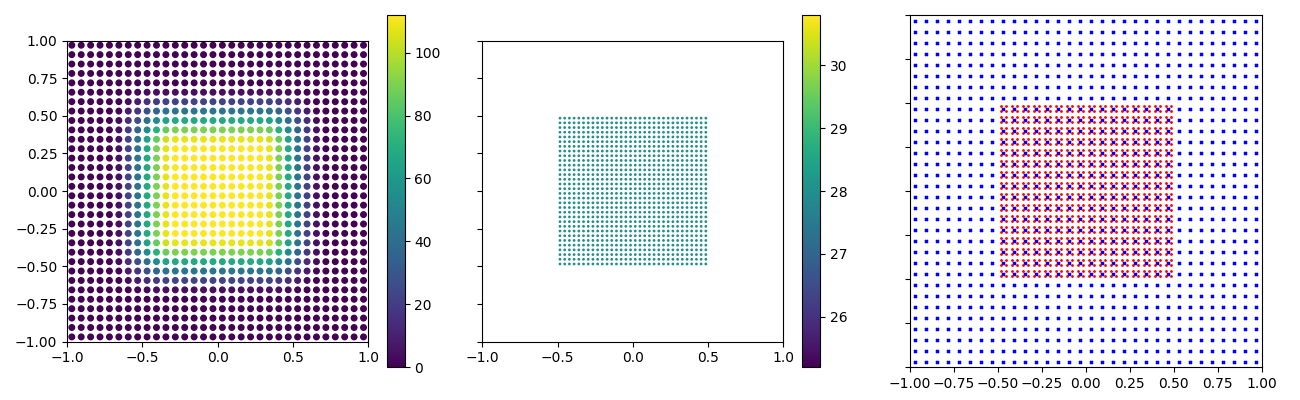

In [7]:
from torchCompactRadius.neighborhood import neighborSearchExisting
i2, j2 = neighborSearchExisting(pointCloudX, hashMap = compactHashMap, mode = 'symmetric', searchRadius = 1, variant = 'cpp', verbose = False)

print(i.shape, i2.shape)
print(j.shape, j2.shape)

jj2, numNeighborsJ2 = countUniqueEntries(j2, y)
ii2, numNeighborsI2 = countUniqueEntries(i2, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI2, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ2, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()